In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Circuit optimization, gate alignment, and spin echoes

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/spin_echoes"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/google/spin_echoes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/google/spin_echoes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/spin_echoes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to prepare circuits to run on the Quantum Computing Service (QCS) and optimize them to improve performace, showing an example of the procedure outlined in the [Best practices guide](https://quantumai.google/cirq/google/best_practices#improving_circuit_fidelity). This is an "advanced" tutorial where you will learn to perform the following optimization techniques:

1. Removing unnecessary gates
2. Aligning 1 and 2 qubit gates
3. Inserting spin echos to reduce leakage & cross-talk.

Note: The function `cirq_google.optimized_for_sycamore` implements some of the optimizations shown here. This tutorial provides more detail for finer control.

## Setup

In [3]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --pre --quiet
    print("installed cirq.")

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import cirq
import cirq_google as cg

Note: Leave the `project_id` and/or `processor_id` blank to use a noisy simulator.

In [5]:
import os

# The Google Cloud Project id to use.
project_id = '' #@param {type:"string"}


if project_id == '':
    import os 
    if 'GOOGLE_CLOUD_PROJECT' not in os.environ:
        raise Exception("Please setup project_id in this cell or set the `GOOGLE_CLOUD_PROJECT` env var to your project id.")
    project_id = os.environ['GOOGLE_CLOUD_PROJECT']
else: 
    import os
    os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

def authenticate_user():
    """Runs the user through the Colab OAuth process.

    Checks for Google Application Default Credentials and runs interactive login 
    if the notebook is executed in Colab. In case the notebook is executed in Jupyter notebook
    or other IPython runtimes, no interactive login is provided, it is assumed that the 
    `GOOGLE_APPLICATION_CREDENTIALS` env var is set or `gcloud auth application-default login`
    was executed already.

    For more information on using Application Default Credentials see 
    https://cloud.google.com/docs/authentication/production
    """
    in_colab = False
    try:
        from IPython import get_ipython
        in_colab = 'google.colab' in str(get_ipython())
    except: 
        # Notebook is not executed within IPython. Assuming external authentication.
        return 

    if in_colab: 
        from google.colab import auth      
        print("Getting OAuth2 credentials.")
        print("Press enter after entering the verification code.")
        auth.authenticate_user(clear_output=False)
        print("Authentication complete.")
    else: 
        print("Notebook is not executed with Colab, assuming Application Default Credentials are setup.") 

authenticate_user()

print("Successful authentication to Google Cloud.")

processor_id = "" #@param {type:"string"}
device = cg.get_engine_device(processor_id)
sampler = cg.get_engine_sampler(processor_id, gate_set_name="sqrt_iswap")

Getting OAuth2 credentials.
Press enter after entering the verification code.
Authentication complete.
Successful authentication to Google Cloud.


In [6]:
# @markdown Helper functions.
from typing import Optional, Sequence
from cirq.experiments import random_rotations_between_grid_interaction_layers_circuit


# Gates for spin echoes.
pi_pulses = [
    cirq.PhasedXPowGate(phase_exponent=p, exponent=1.0) for p in (-0.5, 0.0, 0.5, 1.0)
]


def create_benchmark_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.ISWAP ** 0.5,
    seed: Optional[int] = None,
    with_optimization: bool = False,
    with_alignment: bool = False,
    with_spin_echoes: bool = False,
) -> cirq.Circuit:
    """Returns an "OTOC-like" circuit [1] used to benchmark optimization and/or
    alignment and/or spin echoes.

    Args:
        qubits: Qubits to use.
        cycles: Depth of random rotations in the forward & reverse unitary.
        twoq_gate: Two-qubit gate to use.
        seed: Seed for circuit generation.
        with_optimization: Run a series of optimizations on the circuit.
        with_alignment: Align moments and synchronize terminal measurements.
        with_spin_echoes: Insert spin echoes on ancilla qubit.
    
    References:
        [1] Fig. S10 of https://arxiv.org/abs/2101.08870.
    """
    ancilla, qubits = qubits[0], qubits[1:]

    # Put ancilla into the |1⟩ state and couple it to the rest of the qubits.
    excite_ancilla = [cirq.X(ancilla), twoq_gate(ancilla, qubits[0])]

    # Forward operations.
    forward = random_rotations_between_grid_interaction_layers_circuit(
        qubits, 
        depth=cycles,
        two_qubit_op_factory=lambda a, b, _: twoq_gate.on(a, b),
        pattern=cirq.experiments.GRID_STAGGERED_PATTERN,
        single_qubit_gates=[cirq.PhasedXPowGate(phase_exponent=p, exponent=0.5)
                            for p in np.arange(-1.0, 1.0, 0.25)],
        seed=seed
    )

    # Full circuit. Note: We are intentionally creating a bad circuit structure
    # to show the advantages of optimization & alignment.
    circuit = cirq.Circuit(excite_ancilla)
    circuit.append(forward.all_operations(), strategy=cirq.InsertStrategy.NEW)
    circuit.append(cirq.inverse(forward).all_operations(), strategy=cirq.InsertStrategy.NEW)
    circuit.append(cirq.inverse(excite_ancilla[1:]))
    circuit.append(cirq.measure(ancilla, key="z"), strategy=cirq.InsertStrategy.NEW)

    # Run optimization.
    if with_optimization:
        cirq.MergeInteractionsToSqrtIswap().optimize_circuit(circuit)
        cirq.EjectPhasedPaulis().optimize_circuit(circuit)
        cirq.EjectZ().optimize_circuit(circuit)
        cirq.DropNegligible().optimize_circuit(circuit)
        cirq.DropEmptyMoments().optimize_circuit(circuit)

    # Insert spin echoes. Note: It's important to do this after optimization, as
    # optimization will remove spin echoes.
    if with_spin_echoes:
        random_state = np.random.RandomState(seed)

        spin_echo = []
        for _ in range(cycles * 2):
            op = random_state.choice(pi_pulses).on(ancilla)
            spin_echo += [op, cirq.inverse(op)]

        circuit.insert(2, spin_echo)

    # Alignment.
    if with_alignment:
        cirq.AlignRight().optimize_circuit(circuit)
        cirq.SynchronizeTerminalMeasurements().optimize_circuit(circuit)

    return circuit


def to_survival_prob(result: cirq.Result) -> float:
    return np.mean(np.sum(result.measurements["z"], axis=1) == 1)

## Preparing circuits to run on QCS

For the sake of this tutorial, we will use a circuit structure created by the `create_benchmark_circuit` function defined above.

In [7]:
"""Create an example circuit."""
qubits = [cirq.GridQubit(x, y) for (x, y) in [(3, 2), (4, 2), (4, 1), (5, 1), (6, 1)]]
circuit = create_benchmark_circuit(qubits, cycles=2, seed=1)

print("Example benchmark circuit:\n")
print(circuit)

Example benchmark circuit:

                                                                                                                                                                                                                                                                                                                                                                                                                     ┌─────────────────────────┐
(3, 2): ───X───iSwap─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap─────────────────────────────────────M('z')───
               │                                                  

This circuit divides the qubits into two registers: a single ancilla (top qubit) as the first register, and the remaining qubits as the second register. First, the ancilla is excited into the $|1\rangle$ state and coupled to the second register. Then, a [Loschmidt echo](https://quantumai.google/cirq/tutorials/google/echoes) is performed on the second register. Last, the ancilla is uncoupled from the second register and measured. Without any noise, the only measurement result should be $1$.

In [8]:
"""Without noise, only the 1 state is measured."""
result = cirq.Simulator().run(circuit, repetitions=1000)
result.histogram(key="z")

Counter({1: 1000})

We choose this circuit as an example for two reasons:

1. Each gate in the circuit is in its own `cirq.Moment`, so this is a poor circuit structure to run on devices without any optimization / alignment.

2. The ancilla qubit is idle except at the start and end of the circuit, so this is a prime example where adding spin echoes can improve performance.

A similar circuit was used in [Information Scrambling in Computationally Complex Quantum Circuits](https://arxiv.org/abs/2101.08870) (see Fig. S10) to benchmark the performance of spin echoes.

Starting from this circuit, we show how to optimize gates, align moments, and insert spin echoes to improve the performance on a real device.

### Convert to target gateset

To run on a device, all gates in the circuit will be converted to a gateset supported by that device. (See the [Device specifications guide](https://quantumai.google/cirq/google/specification) for information on supported gatesets.)

We will use the $\sqrt{\text{iSWAP}}$ in this tutorial as an example. To convert gates to this gateset, use the `cirq.MergeInteractionsToSqrtIswap` optimizer.

In [9]:
cirq.MergeInteractionsToSqrtIswap().optimize_circuit(circuit)
circuit

(3, 2): ───X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────M('z')───

(4, 1): ───────────────PhX(-0.25)^0.5─────────────────────────────────────────────PhX(-0.75)^0.5────────────────────────────────────T^-1──────X^0.5───T────────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.25)^-0.5─────────────────────────

(5, 1): ────────────────────────────────PhX(0)^0.5────────────────iSwap────────────────────────────PhX(-0.25)^0.5───────────────────Z^-0.75───X^0.5───Z^0.75───────────────────────────────────────────────────────────────────────────────Z───iSwap───────Z─────────────────X^-0.5────────────────
                                                                  │                                                                                                                                                                            │
(6, 1): ─────────────────────────────────────────────PhX(1)^0.5───iSwap^0.5─────────────────────────────────────────PhX(0.25)^0.5──────────────────────────────────PhX(0)^0.5───────────────PhX(0)^-0.5───────────────────PhX(0.25)^-0.5───────iSwap^0.5───X^0.5───────────────────────────────────

Note: You can compile an arbitrary two-qubit unitary (provided as a matrix) to $\sqrt{\text{iSWAP}}$ operations as shown below. This is useful when using custom gates in a circuit.

In [10]:
"""Compile an arbitrary two-qubit operation to the sqrt_iswap gateset."""
ops = cirq.two_qubit_matrix_to_sqrt_iswap_operations(
    q0=qubits[0], q1=qubits[1], mat=cirq.testing.random_unitary(dim=4)
)
cirq.Circuit(ops)

(3, 2): ───Z^0.078───X^0.368───Z^0.939───iSwap───────Z^-0.391───X^0.002───Z^-0.331───iSwap───────Z^-0.26───X^0.588───Z^0.235───
                                         │                                           │
(4, 2): ───Z^-0.69───X^(5/8)─────────────iSwap^0.5───Z^-0.06────X^0.565──────────────iSwap^0.5───Z^0.82────X^0.472───Z^0.962───

### Remove unnecessary gates (Optimization)

After converting to a target gateset, you can use circuit optimizers to attempt to remove unnecessary gates as shown below.

The `cirq.EjectPhasedPaulis` optimizer pushes `cirq.X`, `cirq.Y`, and `cirq.PhasedXPowGate` gates towards the end of the circuit.

In [11]:
cirq.EjectPhasedPaulis().optimize_circuit(circuit)
circuit

(3, 2): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────!M('z')───

(4, 1): ───────────────PhX(-0.25)^0.5─────────────────────────────────────────────PhX(-0.75)^0.5────────────────────────────────────T^-1──────X^0.5───T────────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.25)^-0.5──────────────────────────

(5, 1): ────────────────────────────────PhX(0)^0.5────────────────iSwap────────────────────────────PhX(-0.25)^0.5───────────────────Z^-0.75───X^0.5───Z^0.75───────────────────────────────────────────────────────────────────────────────Z───iSwap───────Z─────────────────X^-0.5─────────────────
                                                                  │                                                                                                                                                                            │
(6, 1): ─────────────────────────────────────────────PhX(1)^0.5───iSwap^0.5─────────────────────────────────────────PhX(0.25)^0.5──────────────────────────────────PhX(0)^0.5───────────────PhX(0)^-0.5───────────────────PhX(0.25)^-0.5───────iSwap^0.5───X^0.5────────────────────────────────────

Note the measurement symbol on the ancilla is now preceded by an exclamation point (`!`), indicating the measurement is inverted - rather than perform a physical `cirq.X` gate on the ancilla then measure it, the optimizer removed the `cirq.X` and inverted the measurement so that $0 \rightarrow 1$ and $1 \rightarrow 0$.

You can also use the `cirq.EjectZ` optimizer to attempt to push `cirq.Z` gates towards the end of the circuit.

In [12]:
cirq.EjectZ().optimize_circuit(circuit)
circuit

(3, 2): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────!M('z')───

(4, 1): ───────────────PhX(-0.25)^0.5─────────────────────────────────────────────PhX(-0.75)^0.5────────────────────────────────────────PhX(0.25)^0.5───────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.25)^-0.5───────────────────────────────

(5, 1): ────────────────────────────────PhX(0)^0.5────────────────iSwap────────────────────────────PhX(-0.25)^0.5───────────────────────PhX(0.75)^0.5───────────────────────────────────────────────────────────────────────────────────Z───iSwap─────────────────────────PhX(1)^-0.5───Z─────────────
                                                                  │                                                                                                                                                                         │
(6, 1): ─────────────────────────────────────────────PhX(1)^0.5───iSwap^0.5─────────────────────────────────────────PhX(0.25)^0.5───────────────────────────────PhX(0)^0.5───────────────PhX(0)^-0.5───────────────────PhX(0.25)^-0.5───────iSwap^0.5───X^0.5─────────────────────────────────────────

Note that two `cirq.T` gates on the (4, 1) qubit have been removed.

### Align gates in moments (Alignment)

After optimizing, gates should be aligned into `cirq.Moment`s to satisfy the following criteria:

- The fewer moments the better (generally speaking).
  - Each moment is a discrete time slice, so fewer moments means shorter circuit execution time.

- Moments should consist of gates with similar durations.
  - Otherwise some qubits will be idle for part of the moment.
  - It's best to align one-qubit gates in their own moment and two-qubit gates in their own moment if possible.

- All measurements should be terminal and in a single moment.


To align gates into moments and push them as far left as possible, use `cirq.AlignLeft`.

In [13]:
left_aligned_circuit = circuit.copy()
cirq.AlignLeft().optimize_circuit(left_aligned_circuit)
left_aligned_circuit

(3, 2): ───!M('z')───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

(4, 1): ───PhX(-0.25)^0.5───PhX(-0.75)^0.5───PhX(0.25)^0.5────PhX(-0.25)^-0.5────────────────────────────────────────────────────────────────

(5, 1): ───PhX(0)^0.5───────iSwap────────────PhX(-0.25)^0.5───PhX(0.75)^0.5─────Z──────────────────────────────iSwap───────PhX(1)^-0.5───Z───
                            │                                                                                  │
(6, 1): ───PhX(1)^0.5───────iSwap^0.5────────PhX(0.25)^0.5────PhX(0)^0.5────────PhX(0)^-0.5───PhX(0.25)^-0.5───iSwap^0.5───X^0.5─────────────

Note: The measurement is now in the first moment. This can be fixed with `cirq.SynchronizeTerminalMeasurements` as discussed below.

Note how many fewer moments this aligned circuit has.

In [14]:
print(f"Original circuit has {len(circuit)} moments.")
print(f"(Left) Aligned circuit has {len(left_aligned_circuit)} moments.")

Original circuit has 31 moments.
(Left) Aligned circuit has 9 moments.


You can also align gates and push them to the right with `cirq.AlignRight`.

In [15]:
right_aligned_circuit = circuit.copy()
cirq.AlignRight().optimize_circuit(right_aligned_circuit)
right_aligned_circuit

(3, 2): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────!M('z')───────────

(4, 1): ─────────────────────────────────────────────────────────────────────────────PhX(-0.25)^0.5───PhX(-0.75)^0.5───PhX(0.25)^0.5───PhX(-0.25)^-0.5───

(5, 1): ───PhX(0)^0.5───iSwap───────────────────────PhX(-0.25)^0.5───PhX(0.75)^0.5───Z────────────────iSwap────────────PhX(1)^-0.5─────Z─────────────────
                        │                                                                             │
(6, 1): ───PhX(1)^0.5───iSwap^0.5───PhX(0.25)^0.5───PhX(0)^0.5───────PhX(0)^-0.5─────PhX(0.25)^-0.5───iSwap^0.5────────────────────────X^0.5─────────────

Last, you can use `cirq.stratified_circuit` to align operations into similar categories. For example, you can align operations that act on the same number of qubits into moments as follows. 

In [16]:
circuit = cirq.stratified_circuit(circuit, categories=[lambda op: len(op.qubits)])
circuit

(3, 2): ───!M('z')─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

(4, 1): ───PhX(-0.25)^0.5───PhX(-0.75)^0.5───PhX(0.25)^0.5────PhX(-0.25)^-0.5──────────────────────────────────────────────────────

(5, 1): ───PhX(0)^0.5───────iSwap────────────PhX(-0.25)^0.5───PhX(0.75)^0.5─────Z─────────────PhX(1)^-0.5──────iSwap───────Z───────
                            │                                                                                  │
(6, 1): ───PhX(1)^0.5───────iSwap^0.5────────PhX(0.25)^0.5────PhX(0)^0.5────────PhX(0)^-0.5───PhX(0.25)^-0.5───iSwap^0.5───X^0.5───

### Drop moments

To drop moments that have a tiny effect or moments that are empty, you can use the following optimizers.

In [17]:
cirq.DropNegligible().optimize_circuit(circuit)
cirq.DropEmptyMoments().optimize_circuit(circuit)
circuit

(3, 2): ───!M('z')─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

(4, 1): ───PhX(-0.25)^0.5───PhX(-0.75)^0.5───PhX(0.25)^0.5────PhX(-0.25)^-0.5──────────────────────────────────────────────────────

(5, 1): ───PhX(0)^0.5───────iSwap────────────PhX(-0.25)^0.5───PhX(0.75)^0.5─────Z─────────────PhX(1)^-0.5──────iSwap───────Z───────
                            │                                                                                  │
(6, 1): ───PhX(1)^0.5───────iSwap^0.5────────PhX(0.25)^0.5────PhX(0)^0.5────────PhX(0)^-0.5───PhX(0.25)^-0.5───iSwap^0.5───X^0.5───

### Synchronize terminal measurements

You can use the `cirq.SynchronizeTerminalMeasurements` to move all measurements to the final moment if it can accommodate them (without overlapping with other operations).

In [18]:
cirq.SynchronizeTerminalMeasurements().optimize_circuit(circuit)
circuit

(3, 2): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────!M('z')───

(4, 1): ───PhX(-0.25)^0.5───PhX(-0.75)^0.5───PhX(0.25)^0.5────PhX(-0.25)^-0.5────────────────────────────────────────────────────────────────

(5, 1): ───PhX(0)^0.5───────iSwap────────────PhX(-0.25)^0.5───PhX(0.75)^0.5─────Z─────────────PhX(1)^-0.5──────iSwap───────Z─────────────────
                            │                                                                                  │
(6, 1): ───PhX(1)^0.5───────iSwap^0.5────────PhX(0.25)^0.5────PhX(0)^0.5────────PhX(0)^-0.5───PhX(0.25)^-0.5───iSwap^0.5───X^0.5─────────────

## Adding spin echoes

[Dynamical decoupling](https://arxiv.org/abs/quant-ph/9803057) applies a series of spin echoes to otherwise idle qubits to reduce decoherent effects. As mentioned above, spin echoes were used as an effective error mitigation technique in [Information Scrambling in Computationally Complex Quantum Circuits](https://arxiv.org/abs/2101.08870), and the performance of any circuit with idle qubits can potentially be improved by adding spin echoes.

The following codeblock shows how to insert spin echoes on the ancilla qubit.

In [19]:
# Gates for spin echoes. Note that these gates are self-inverse.
pi_pulses = [
    cirq.PhasedXPowGate(phase_exponent=p, exponent=1.0) for p in (-0.5, 0.0, 0.5, 1.0)
]

# Generate spin echoes on ancilla.
num_echoes = 4
random_state = np.random.RandomState(1)

spin_echo = []
for _ in range(num_echoes):
    op = random_state.choice(pi_pulses).on(qubits[0])
    spin_echo += [op, cirq.inverse(op)]

# Insert spin echo operations to circuit.
optimized_circuit_with_spin_echoes = circuit.copy()
optimized_circuit_with_spin_echoes.insert(1, spin_echo)
optimized_circuit_with_spin_echoes

(3, 2): ───PhX(0)───────────PhX(0)───────────PhX(1)───────────PhX(1)────────────PhX(-0.5)─────PhX(-0.5)────────PhX(-0.5)───PhX(-0.5)───!M('z')───

(4, 1): ───PhX(-0.25)^0.5───PhX(-0.75)^0.5───PhX(0.25)^0.5────PhX(-0.25)^-0.5────────────────────────────────────────────────────────────────────

(5, 1): ───PhX(0)^0.5───────iSwap────────────PhX(-0.25)^0.5───PhX(0.75)^0.5─────Z─────────────PhX(1)^-0.5──────iSwap───────Z─────────────────────
                            │                                                                                  │
(6, 1): ───PhX(1)^0.5───────iSwap^0.5────────PhX(0.25)^0.5────PhX(0)^0.5────────PhX(0)^-0.5───PhX(0.25)^-0.5───iSwap^0.5───X^0.5─────────────────

The ancilla now has spin echoes before the measurement instead of remaining idle.

## Benchmark

Now that we have discussed how to remove uncessary gates, align gates, and insert spin echoes, we run an experiment to benchmark the results. First we get a line of qubits, list of cycle values (one circuit per cycle value), and set other experimental parameters.

In [20]:
"""Set experiment parameters."""
qubits = cg.line_on_device(device, length=7)
cycle_values = range(0, 100 + 1, 4)
nreps = 20_000
seed = 1

The `create_benchmark_circuit` defined at the start of this tutorial has options to optimize the circuit and insert spin echoes on the ancilla as we have discussed above. Without any optimization or spin echoes, an example circuit looks like this:

In [21]:
circuit = create_benchmark_circuit(qubits, cycles=2, seed=1)
print(f"Unoptimized circuit ({len(circuit)} moments):\n")
print(circuit)

Unoptimized circuit (47 moments):

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ┌─────────────────────────┐
(3, 2): ───X───iSwap─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

After removing unecessary gates (optimization) and aligning gates, the same circuit looks like this:

In [22]:
optimized_circuit = create_benchmark_circuit(qubits, cycles=2, seed=1, with_optimization=True, with_alignment=True)
print(f"Circuit with optimization + alignment ({len(optimized_circuit)} moments):\n")
print(optimized_circuit)

Circuit with optimization + alignment (15 moments):

                                                                                                                                                  ┌────────────────────────────┐                                     ┌─────────────────────────┐
(3, 2): ───PhX(0)───iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Z────────────────iSwap──────────────────────────────────────────M('z')───
                    │                                                                                                                                                                                                 │
(4, 1): ────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.25)^0.5────PhX(0.25)^0.5────┼────

And with optimization + alginment + spin echoes on the ancilla, the same circuit looks like this:

In [23]:
optimized_circuit_with_spin_echoes = create_benchmark_circuit(qubits, cycles=2, seed=1, with_optimization=True, with_alignment=True, with_spin_echoes=True)
print(f"Circuit with optimization + alignment + spin echoes ({len(optimized_circuit_with_spin_echoes)} moments):\n")
print(optimized_circuit_with_spin_echoes)

Circuit with optimization + alignment + spin echoes (15 moments):

                                                                                                                                                  ┌────────────────────────────┐                                     ┌─────────────────────────┐
(3, 2): ───PhX(0)───iSwap────────────────────────PhX(0)──────PhX(0)───────────PhX(1)──────────PhX(1)───────────PhX(-0.5)─────────PhX(-0.5)─────────PhX(-0.5)───────────────────────PhX(-0.5)─────────Z────────────────iSwap──────────────────────────────────────────M('z')───
                    │                                                                                                                                                                                                 │
(4, 1): ────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.25)^0.5────PhX(0.25

Now we create circuits for all cycle values without optimization, with optimization + alignment, and with optimization + alignment + spin echoes.

In [24]:
"""Create all circuits."""
batch = [
    create_benchmark_circuit(qubits, cycles=c, seed=seed)
    for c in cycle_values
]
batch_with_optimization = [
    create_benchmark_circuit(qubits, cycles=c, seed=seed, with_optimization=True, with_alignment=True)
    for c in cycle_values
]
batch_with_optimization_and_spin_echoes = [
    create_benchmark_circuit(qubits, cycles=c, seed=seed, with_optimization=True, with_alignment=True, with_spin_echoes=True)
    for c in cycle_values
]

The next cell runs them on the device.

In [25]:
"""Run all circuits."""
all_probs = []
for b in (batch, batch_with_optimization, batch_with_optimization_and_spin_echoes):
    results = sampler.run_batch(b, repetitions=nreps)
    all_probs.append([to_survival_prob(*res) for res in results])

And the next cell plots the results.

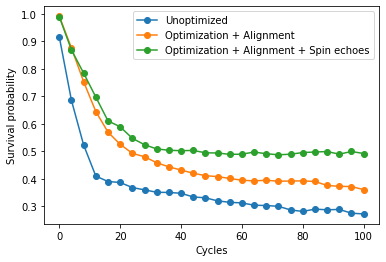

In [26]:
"""Plot results."""
labels = ["Unoptimized", "Optimization + Alignment", "Optimization + Alignment + Spin echoes"]

for (probs, label) in zip(all_probs, labels):
    plt.plot(cycle_values, probs, "-o", label=label)

plt.xlabel("Cycles")
plt.ylabel("Survival probability")
plt.legend();

Recall that without any noise, the survival probability (ratio of $1$s measured to all measurements) should be $1.0$, so higher on this plot is better. The unoptimized circuit performs the worst, the circuit with optimization + alignment performs better, and the circuit with optimization + alignment + spin echoes performs the best.